In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# summary info on models
from torchsummary import summary

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

C:\Users\DOANTR~1\AppData\Local\Temp/ipykernel_18268/2973059004.py:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Create Gaussian blurs with different widths

In [3]:
n_per_class = 1000 # Total 2000 images
img_size    = 91

x    = np.linspace(start=-4, stop=4, num=img_size)
X, Y = np.meshgrid(x, x)

# The two widths (a.u.) sigma
widths = [1.8, 2.4]

# Initialize tensors containing images and labels
images = torch.zeros(2 * n_per_class, 1, img_size, img_size)
labels = torch.zeros(2 * n_per_class)

for i in range(2 * n_per_class):
    
    # Create the gaussian with random centers
    # Ro = random offset
    # `i % 2`: Even image belong to label 0
    ro = 2 * np.random.randn(2)
    G  = np.exp(-((X - ro[0]) ** 2 + (Y - ro[1]) ** 2) / (2 * widths[i % 2] ** 2))
    
    # And add noise
    G += np.random.randn(img_size, img_size) / 5
    
    # Add to the tensor
    # `.view`: Convert from numpy matrix to PTorch Tensor
    images[i, :, :, :] = torch.tensor(G).view(1, img_size, img_size)
    labels[i]          = i % 2

labels = labels[:, None]

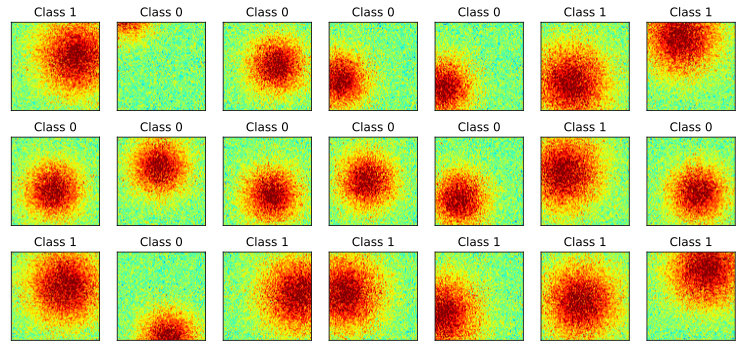

In [4]:
# Visualize some images
fig, axs = plt.subplots(3, 7, figsize=(13, 6))

for i, ax in enumerate(axs.flatten()):
    which_pic = np.random.randint(2 * n_per_class)
    G         = np.squeeze(images[which_pic, :, :])
    ax.imshow(G, vmin=-1, vmax=1, cmap='jet')
    ax.set_title(f'Class {int(labels[which_pic].item())}')
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

# Create train/test groups using DataLoader

In [7]:
# Use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(images, labels, test_size=0.1)

# Convert into PyTorch Datasets
train_data_set = TensorDataset(train_data, train_labels)
test_data_set  = TensorDataset(test_data, test_labels)

# Translate into Dataloader objects
batch_size   = 32
train_loader = DataLoader(dataset=train_data_set, batch_size=batch_size,
                        shuffle=True, drop_last=True)
test_loader  = DataLoader(dataset=test_data_set, 
                        batch_size=test_data_set.tensors[0].shape[0])

In [8]:
# Check size (should be images X channels X width X height
print(train_loader.dataset.tensors[0].shape)
print(train_loader.dataset.tensors[1].shape)

torch.Size([1800, 1, 91, 91])
torch.Size([1800, 1])


# Create the DL model

In [9]:
def make_the_net():
    """
    CNN_CLASSIFY_GAUSSIAN_BLURS
    """
    class gauss_net(nn.Module):
        def __init__(self):
            super().__init__()
            
            # All layers in one go using nn.Sequential
            self.enc = nn.Sequential(
                nn.Conv2d(1, 6, kernel_size=3, padding=1),  # (91 + 2*1 -3)/1 + 1 = 91
                nn.ReLU(),                                  # Treated like a "layer"
                nn.AvgPool2d(2, 2),                         # 91 / 2 = 45
                
                
                nn.Conv2d(6, 4, kernel_size=3, padding=1),  # (45 +2*1 -3)/1 + 1 = 45
                nn.ReLU(),
                nn.AvgPool2d(2, 2),                         # 45 / 2 = 22
                
                nn.Flatten(),                               # Vectorize conv output
                nn.Linear(22 * 22 * 4, 50),                 # 50
                nn.Linear(50, 1)                            # 1
            )
        
        def forward(self, x):
            return self.enc(x)
        
    
    # Create the model instance
    net = gauss_net()
    
    # Loss Function
    loss_func = nn.BCEWithLogitsLoss()
    
    # Optimizer
    optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001)
    
    return net, loss_func, optimizer

In [11]:
# Test the model with one batch
net, loss_func, optimizer = make_the_net()

X, y = iter(train_loader).next()
y_hat = net(X)

print(''), print(y_hat.shape)

loss = loss_func(y_hat, y)
print(f'Loss: {loss}')


torch.Size([32, 1])
Loss: 0.6817405819892883


In [12]:
# Count the total number of parameters in the model
summary(net, (1, img_size, img_size))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Conv2d: 2-1                       [-1, 6, 91, 91]           60
|    └─ReLU: 2-2                         [-1, 6, 91, 91]           --
|    └─AvgPool2d: 2-3                    [-1, 6, 45, 45]           --
|    └─Conv2d: 2-4                       [-1, 4, 45, 45]           220
|    └─ReLU: 2-5                         [-1, 4, 45, 45]           --
|    └─AvgPool2d: 2-6                    [-1, 4, 22, 22]           --
|    └─Flatten: 2-7                      [-1, 1936]                --
|    └─Linear: 2-8                       [-1, 50]                  96,850
|    └─Linear: 2-9                       [-1, 1]                   51
Total params: 97,181
Trainable params: 97,181
Non-trainable params: 0
Total mult-adds (M): 1.08
Input size (MB): 0.03
Forward/backward pass size (MB): 0.44
Params size (MB): 0.37
Estimated Total Size (MB): 0.84


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Conv2d: 2-1                       [-1, 6, 91, 91]           60
|    └─ReLU: 2-2                         [-1, 6, 91, 91]           --
|    └─AvgPool2d: 2-3                    [-1, 6, 45, 45]           --
|    └─Conv2d: 2-4                       [-1, 4, 45, 45]           220
|    └─ReLU: 2-5                         [-1, 4, 45, 45]           --
|    └─AvgPool2d: 2-6                    [-1, 4, 22, 22]           --
|    └─Flatten: 2-7                      [-1, 1936]                --
|    └─Linear: 2-8                       [-1, 50]                  96,850
|    └─Linear: 2-9                       [-1, 1]                   51
Total params: 97,181
Trainable params: 97,181
Non-trainable params: 0
Total mult-adds (M): 1.08
Input size (MB): 0.03
Forward/backward pass size (MB): 0.44
Params size (MB): 0.37
Estimated Total Size (MB): 0.84

# Create a function that trains the model

In [14]:
def train_the_model():
    """
    CNN_CLASSIFY_GAUSSIAN_BLURS
    """
    
    num_epochs = 10

    # Create a new model
    net, loss_func, optimizer = make_the_net()

    # Initialize
    train_loss = torch.zeros(num_epochs)
    test_loss  = torch.zeros(num_epochs)
    train_acc  = torch.zeros(num_epochs)
    test_acc   = torch.zeros(num_epochs)

    # Loop over epochs
    for epoch_i in range(num_epochs):

        # Loop over training data batches
        batch_acc  = []
        batch_loss = [] 

        for X, y in train_loader:
            # Forward pass and loss
            y_hat = net(X)
            loss  = loss_func(y_hat,y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss from this batch
            batch_loss.append(loss.item())
            batch_acc .append(torch.mean(((y_hat > 0) == y).float()).item())

        # End of batch loop.

        # Get the average training accuracy of the batches
        train_loss[epoch_i] = np.mean(batch_loss)
        train_acc [epoch_i] = 100 * np.mean(batch_acc)

        # Test accuracy
        X, y = next(iter(test_loader)) # Extract X, y from dataloader
        with torch.no_grad():
            y_hat = net(X)
            loss  = loss_func(y_hat, y)
            
        test_loss[epoch_i] = loss.item()
        test_acc [epoch_i] = 100 * torch.mean(((y_hat > 0) == y).float()).item()

    # End epochs

    return train_loss, test_loss, train_acc, test_acc, net

# Run the model and show the results!

In [15]:
train_loss, test_loss, train_acc, test_acc, net = train_the_model()

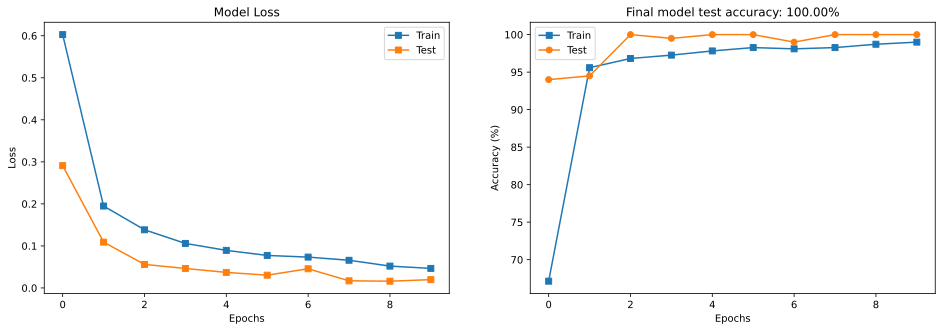

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(train_loss, 's-', label='Train')
ax[0].plot(test_loss,  's-', label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model Loss')
ax[0].legend()

ax[1].plot(train_acc, 's-', label='Train')
ax[1].plot(test_acc,  'o-', label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {test_acc[-1]:.2f}%')
ax[1].legend()

plt.show()

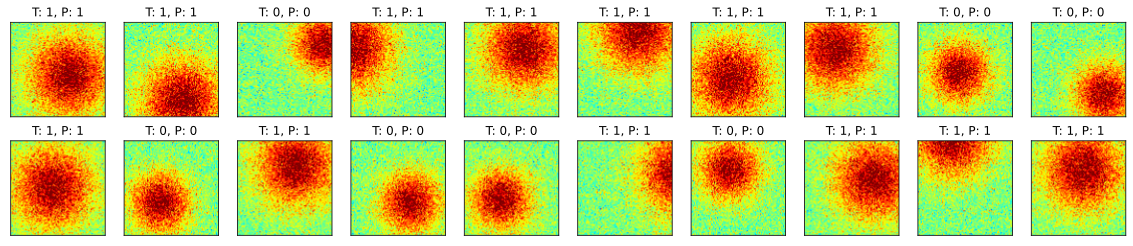

In [ ]:
# Visualize some images
X, y = next(iter(test_loader))
y_hat = net(X)

fig, axs = plt.subplots(2, 10, figsize=(20, 4))

for i, ax in enumerate(axs.flatten()):
    G = torch.squeeze(X[i, 0, :, :]).detach()
    ax.imshow(G, vmin=-1, vmax=1, cmap='jet')
    t = (int(y[i].item()), int(y_hat[i].item() > 0))
    ax.set_title(f'T: {t[0]}, P: {t[1]}')
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [21]:
# Look at the filters
print(net)

layer_1W = net.enc[0].weight
layer_3W = net.enc[3].weight

print('')
print(layer_1W.shape)
print(layer_3W.shape)

gauss_net(
  (enc): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1936, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
)

torch.Size([6, 1, 3, 3])
torch.Size([4, 6, 3, 3])


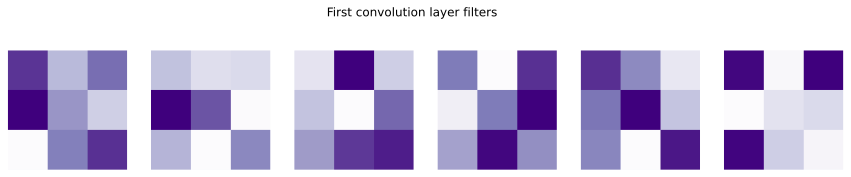

In [22]:
fig, axs = plt.subplots(1, 6, figsize=(15, 3))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(torch.squeeze(layer_1W[i, :, :, :]).detach(), cmap='Purples')
    ax.axis('off')

plt.suptitle('First convolution layer filters')
plt.show()

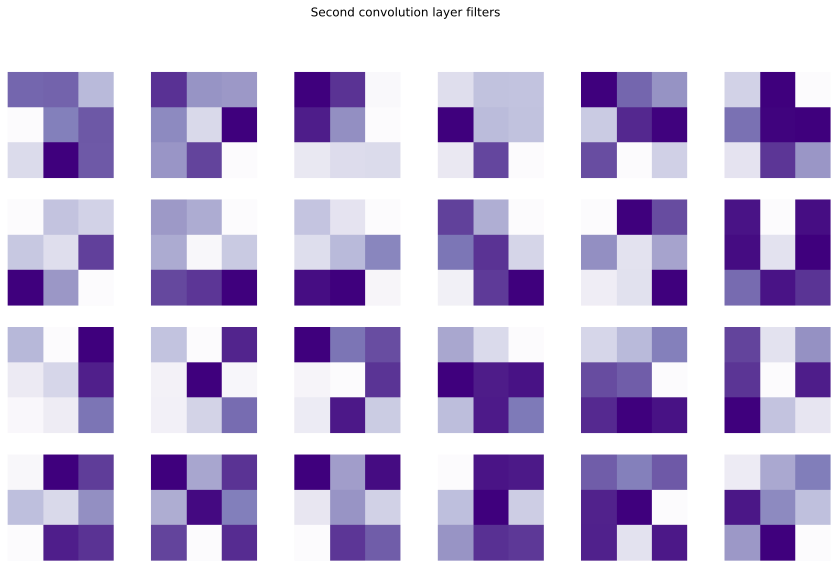

In [25]:
fig, axs = plt.subplots(4, 6, figsize=(15, 9))

for i in range(6 * 4):
    idx = np.unravel_index(indices=i, shape=(4, 6))
    axs[idx].imshow(torch.squeeze(layer_3W[idx[0], idx[1], :, :]).detach(), cmap='Purples')
    axs[idx].axis('off')

plt.suptitle('Second convolution layer filters')
plt.show()

# Additional explorations

In [ ]:
# 1) Rewrite the model architecture without using nn.Sequential. Your final result must be the same as the current version,
#    just defined in a different way. This is great practice at constructing models using classes. 
# 
# 2) Find and plot the stimuli that the model guessed incorrectly. Is the correct answer obvious to you? Do the errors
#    tend to be obscured by the boundaries of the image, or is there any other reason you can find for why the model got
#    those wrong?
# 
# 3) Notice the choice of architecture here: 6 channels in the first convolution layer and 4 channels in the second. In
#    the lecture I said that CNNs typically get wider with each successive "convpool block." Does that mean that this
#    model is wrong? Or suboptimal? Think of some arguments for and against this organization. Then modify the code to
#    swap the widths (4 channels in the first conv layer and 6 channels in the second conv layer). Does that affect the
#    model's performance?
# 